# Building a Fake News Classifier

https://towardsdatascience.com/building-a-fake-news-classifier-using-natural-language-processing-83d911b237e1

## Import Libraries

In [2]:
# API scrape 
from psaw import PushshiftAPI

# Basic libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Scrape

### API Scrape Function

In [3]:
def scrape_data(subreddit):
    
    # Instantiate 
    api = PushshiftAPI()

    # Create list of scraped data
    scrape_list = list(api.search_submissions(subreddit=subreddit,
                                filter=['title', 'subreddit', 'num_comments', 'author', 'subreddit_subscribers', 'score', 'domain', 'created_utc'],
                                limit=15000))

    #Filter list to only show Subreddit titles and Subreddit category 
    clean_scrape_lst = []
    for i in range(len(scrape_list)):
        scrape_dict = {}
        scrape_dict['subreddit'] = scrape_list[i][5]
        scrape_dict['author'] = scrape_list[i][0]
        scrape_dict['domain'] = scrape_list[i][2]
        scrape_dict['title'] = scrape_list[i][7]
        scrape_dict['num_comments'] = scrape_list[i][3]
        scrape_dict['score'] = scrape_list[i][4]
        scrape_dict['timestamp'] = scrape_list[i][1]
        clean_scrape_lst.append(scrape_dict)

    # Show number of subscribers
    print(subreddit, 'subscribers:',scrape_list[1][6])
    
    # Return list of scraped data
    return clean_scrape_lst

### Scrape r/nottheonion

In [4]:
# Call function and create DataFrame
df_not_onion = pd.DataFrame(scrape_data('nottheonion'))

# Save data to csv
df_not_onion.to_csv('./data/not_onion.csv')

# Shape of DataFrame
print(f'df_not_onion shape: {df_not_onion.shape}')

# Show head
df_not_onion.head()

nottheonion subscribers: 17019635
df_not_onion shape: (15000, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,nottheonion,turtwig33,cnn.com,"No screaming, please: Japan amusement parks is...",3,1,1591602185
1,nottheonion,backpackHoarder,foxnews.com,Man tormented by mystery pizza deliveries to h...,0,1,1591601037
2,nottheonion,1970251510,twitter.com,#FREEDOM#DEMOCRACY#FUTURE#HOPE#STAND WITH DEMO...,1,1,1591600365
3,nottheonion,TodayinHistoryWiki,technicalhistorian01.blogspot.com,The volcanic eruption that lasted for 8 months...,1,1,1591599875
4,nottheonion,1970251510,twitter.com,#FREEDOM#DEMOCRACY#FUTURE#HOPE#STAND WITH DEMO...,2,1,1591599834


### Scrape r/TheOnion

In [5]:
# Call function and create DataFrame
df_onion = pd.DataFrame(scrape_data('theonion'))

# Save data to csv
df_onion.to_csv('./data/the_onion.csv')

# Shape of DataFrame
print(f'df_onion shape: {df_onion.shape}')

# Show head
df_onion.head()

theonion subscribers: 148426
df_onion shape: (14978, 7)


,subreddit,author,domain,title,num_comments,score,timestamp
0,TheOnion,Askalany,local.theonion.com,Family Left Elderly Grandmother To Die In Nurs...,1,1,1591567259
1,TheOnion,Askalany,theonion.com,Supreme Court Overturns 'Right v. Wrong',4,1,1591566975
2,TheOnion,boomernot,theonion.com,Auntie Anne’s Breaks From Pack By Calling For ...,21,1,1591545442
3,TheOnion,zirayaacg,theonion.com,Trump Throws Garbage Can Through McDonald’s Wi...,32,1,1591480508
4,TheOnion,zirayaacg,i.redd.it,oh no! not the big macs!,1,1,1591478748


### Import Data

In [6]:
# If you're running this notebook, you can begin with this cell as the data has already been saved to a csv

# r/TheOnion DataFrame
df_onion = pd.read_csv('./data/the_onion.csv')

# r/nottheonion DataFrame
df_not_onion = pd.read_csv('./data/not_onion.csv')

### Preview df_onion

In [7]:
# Show first 5 rows of df_onion
print("Shape:", df_onion.shape)
df_onion.head()

Shape: (14978, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,Askalany,local.theonion.com,Family Left Elderly Grandmother To Die In Nurs...,1,1,1591567259
1,1,TheOnion,Askalany,theonion.com,Supreme Court Overturns 'Right v. Wrong',4,1,1591566975
2,2,TheOnion,boomernot,theonion.com,Auntie Anne’s Breaks From Pack By Calling For ...,21,1,1591545442
3,3,TheOnion,zirayaacg,theonion.com,Trump Throws Garbage Can Through McDonald’s Wi...,32,1,1591480508
4,4,TheOnion,zirayaacg,i.redd.it,oh no! not the big macs!,1,1,1591478748


### Preview df_not_onion

In [8]:
# Show first 5 rows of df_not_onion
print("Shape:", df_not_onion.shape)
df_not_onion.head()

Shape: (15000, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,turtwig33,cnn.com,"No screaming, please: Japan amusement parks is...",3,1,1591602185
1,1,nottheonion,backpackHoarder,foxnews.com,Man tormented by mystery pizza deliveries to h...,0,1,1591601037
2,2,nottheonion,1970251510,twitter.com,#FREEDOM#DEMOCRACY#FUTURE#HOPE#STAND WITH DEMO...,1,1,1591600365
3,3,nottheonion,TodayinHistoryWiki,technicalhistorian01.blogspot.com,The volcanic eruption that lasted for 8 months...,1,1,1591599875
4,4,nottheonion,1970251510,twitter.com,#FREEDOM#DEMOCRACY#FUTURE#HOPE#STAND WITH DEMO...,2,1,1591599834



## Clean Data


### Data Cleaning Function

In [9]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)
    
    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

### Clean df_onion

In [10]:
# Call `clean_data(dataframe)` function
clean_data(df_onion)

New shape: (14013, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,TheOnion,Askalany,local.theonion.com,family left elderly grandmother to die in nurs...,1,1,1591567259
1,1,TheOnion,Askalany,theonion.com,supreme court overturns right v wrong,4,1,1591566975
2,2,TheOnion,boomernot,theonion.com,auntie anne s breaks from pack by calling for ...,21,1,1591545442
3,3,TheOnion,zirayaacg,theonion.com,trump throws garbage can through mcdonald s wi...,32,1,1591480508
4,4,TheOnion,zirayaacg,i.redd.it,oh no not the big macs,1,1,1591478748


### Clean df_not_onion

In [11]:
# Call `clean_data(dataframe)` function
clean_data(df_not_onion)

New shape: (11802, 8)


,Unnamed: 0,subreddit,author,domain,title,num_comments,score,timestamp
0,0,nottheonion,turtwig33,cnn.com,no screaming please japan amusement parks issu...,3,1,1591602185
1,1,nottheonion,backpackHoarder,foxnews.com,man tormented by mystery pizza deliveries to h...,0,1,1591601037
2,2,nottheonion,1970251510,twitter.com,freedom democracy future hope stand with demo...,1,1,1591600365
3,3,nottheonion,TodayinHistoryWiki,technicalhistorian01.blogspot.com,the volcanic eruption that lasted for months a...,1,1,1591599875
5,5,nottheonion,jsdavis,jsonline.com,shorewood woman filmed spitting on protester a...,1,1,1591599331


### Check Nulls

In [12]:
# Create a DataFrame to check nulls
pd.DataFrame([df_onion.isnull().sum(),df_not_onion.isnull().sum()], index=["TheOnion","notheonion"]).T

,TheOnion,notheonion
Unnamed: 0,0,0
subreddit,0,0
author,0,0
domain,0,0
title,0,0
num_comments,0,0
score,0,0
timestamp,0,0



## Exploratory Data Analysis (EDA)

### Date Range of Scraped Posts

In [13]:
# Convert Unix Timestamp to Datetime
df_onion['timestamp'] = pd.to_datetime(df_onion['timestamp'], unit='s')
df_not_onion['timestamp'] = pd.to_datetime(df_not_onion['timestamp'], unit='s')

# Show date-range of posts scraped from r/TheOnion and r/nottheonion
print("TheOnion start date:", df_onion['timestamp'].min())
print("TheOnion end date:", df_onion['timestamp'].max())
print("nottheonion start date:", df_not_onion['timestamp'].min())
print("nottheonion end date:", df_not_onion['timestamp'].max())

TheOnion start date: 2016-07-21 18:28:33
TheOnion end date: 2020-06-07 22:00:59
nottheonion start date: 2020-03-25 03:35:08
nottheonion end date: 2020-06-08 07:43:05


### Bar Plot Function

In [14]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)


### r/TheOnion: Most Active Authors

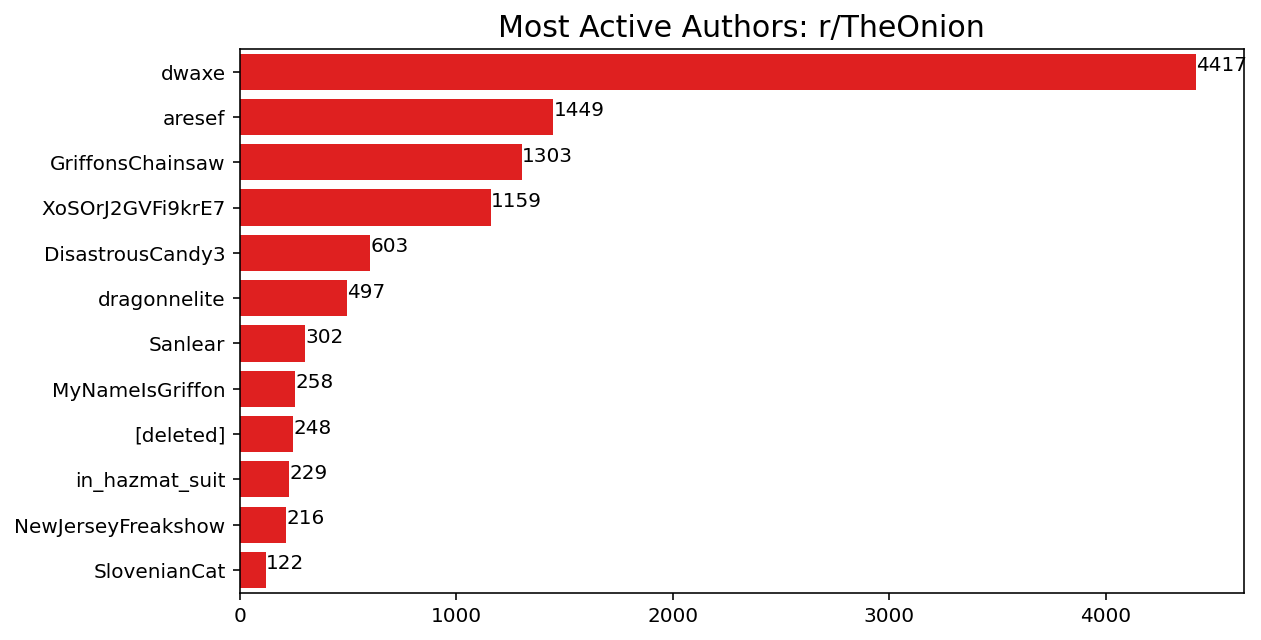

In [15]:
# Set x values: # of posts 
df_onion_authors = df_onion['author'].value_counts() 
df_onion_authors = df_onion_authors[df_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors 
df_onion_authors_index = list(df_onion_authors.index)

# Call function
bar_plot(df_onion_authors.values, df_onion_authors_index, 'Most Active Authors: r/TheOnion', 'r')



### r/nottheonion: Most Active Authors

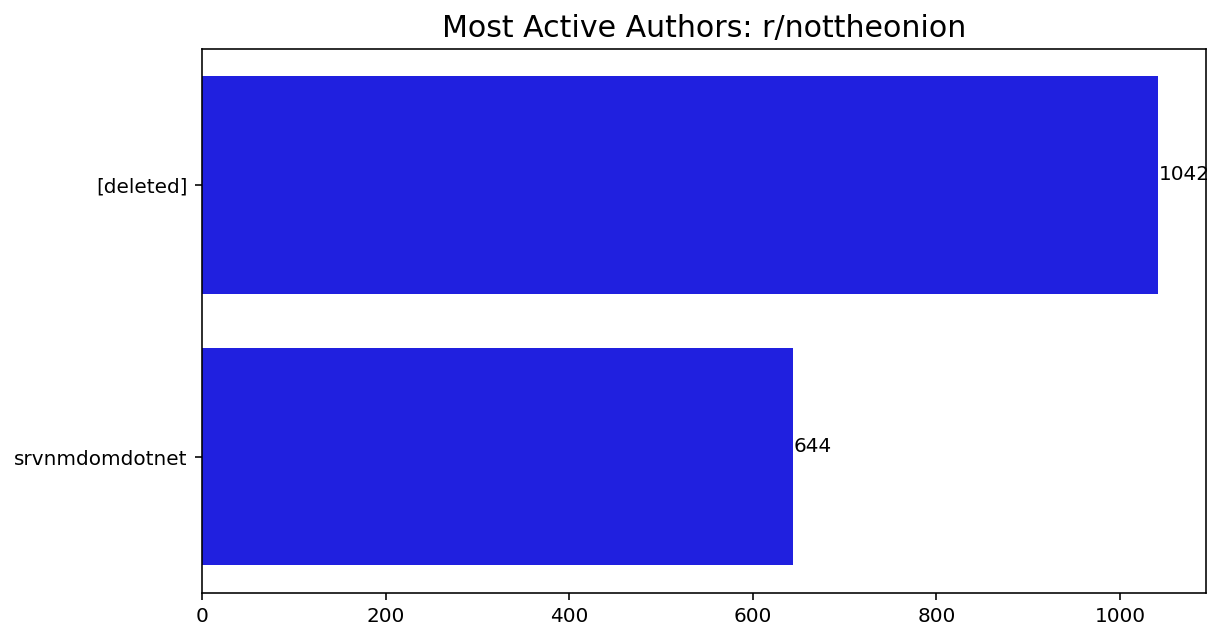

In [16]:
# Set x values: # of posts
df_not_onion_authors = df_not_onion['author'].value_counts() 
df_not_onion_authors = df_not_onion_authors[df_not_onion_authors > 100].sort_values(ascending=False)

# Set y values: Authors
df_not_onion_authors_index = list(df_not_onion_authors.index)

# Call function
bar_plot(df_not_onion_authors.values, df_not_onion_authors_index, 'Most Active Authors: r/nottheonion','b')


### r/TheOnion: Most Referenced Domains

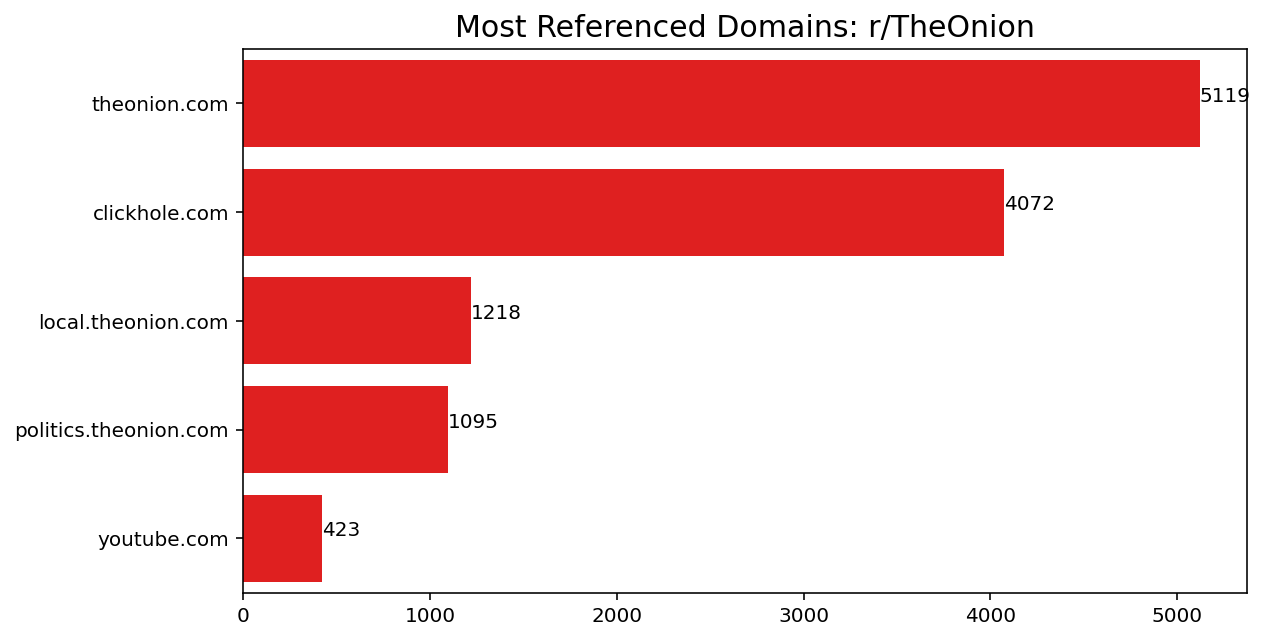

In [17]:
# Set x values: # of posts
df_onion_domain = df_onion['domain'].value_counts() 
df_onion_domain = df_onion_domain.sort_values(ascending=False).head(5)

# Set y values: Domains 
df_onion_domain_index = list(df_onion_domain.index)

# Call function
bar_plot(df_onion_domain.values, df_onion_domain_index, 'Most Referenced Domains: r/TheOnion','r')


### r/nottheonion: Most Referenced Domains

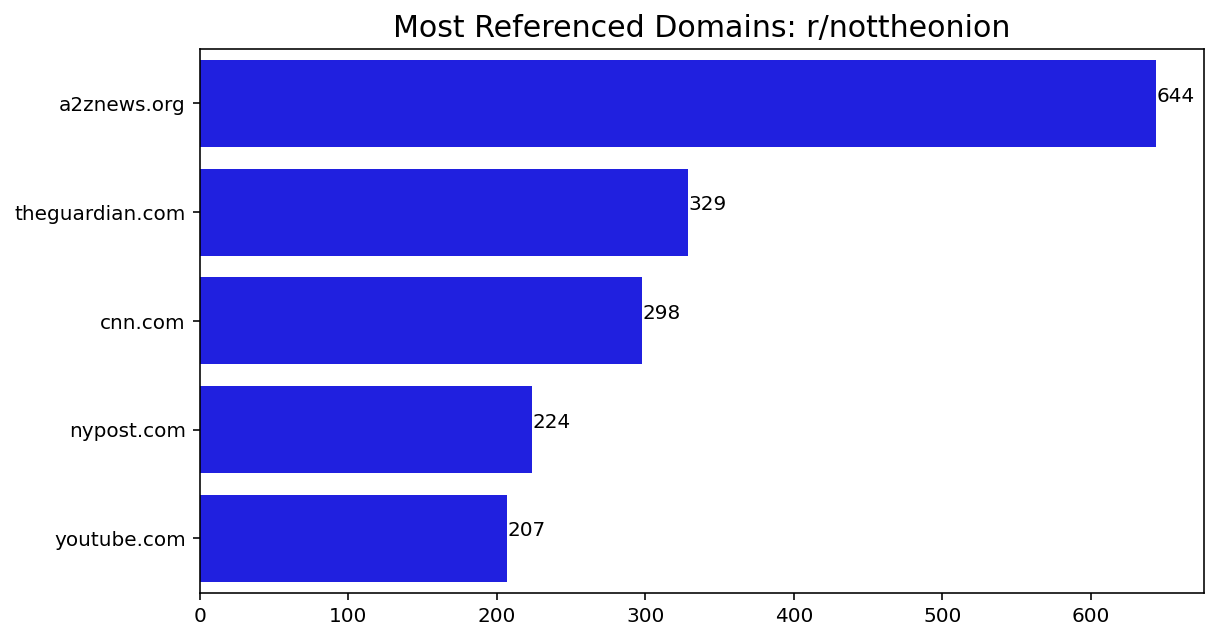

In [18]:
# Set x values: # of posts greater than 100
df_nonion_domain = df_not_onion['domain'].value_counts() 
df_nonion_domain = df_nonion_domain.sort_values(ascending=False).head(5)

# Set y values: Names of authors 
df_nonion_domain_index = list(df_nonion_domain.index)

# Call function
bar_plot(df_nonion_domain.values, df_nonion_domain_index, 'Most Referenced Domains: r/nottheonion','b')

## Natural Language Processing (NLP)

### Concatenate DataFrames

In [19]:
# Combine df_onion & df_not_onion with only 'subreddit' (target) and 'title' (predictor) columns
df = pd.concat([df_onion[['subreddit', 'title']], df_not_onion[['subreddit', 'title']]], axis=0)

#Reset the index
df = df.reset_index(drop=True)

# Preview head of df to show 'TheOnion' titles appear
df.head(2)

,subreddit,title
0,TheOnion,family left elderly grandmother to die in nurs...
1,TheOnion,supreme court overturns right v wrong


In [20]:
# Preview head of df to show 'nottheonion' titles appear
df.tail(2)

,subreddit,title
25813,nottheonion,alleged home invader leaves poop on victim s f...
25814,nottheonion,kentucky patient gets coronavirus after attend...


### Binarize Target subreddit

In [21]:
# Replace `TheOnion` with 1, `nottheonion` with 0
df["subreddit"] = df["subreddit"].map({"nottheonion": 0, "TheOnion": 1})

# Print shape of df
print(df.shape)

# Preview head of df to show 1s
df.head(2)

(25815, 2)


,subreddit,title
0,1,family left elderly grandmother to die in nurs...
1,1,supreme court overturns right v wrong


In [22]:
# Preview tail of df to show 0s
df.tail(2)

,subreddit,title
25813,0,alleged home invader leaves poop on victim s f...
25814,0,kentucky patient gets coronavirus after attend...



## Apply CountVectorizer()
### Count Vectorize df where subreddit is 1

In [23]:
# Set variables to show TheOnion Titles
mask_on = df['subreddit'] == 1
df_onion_titles = df[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
onion_cvec = cv1.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14013, 15065)


### Count Vectorize df where subreddit is 0

In [24]:
# Set variables to show NotTheOnion Titles
mask_no = df['subreddit'] == 0
df_not_onion_titles = df[mask_no]['title']

# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv2.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11802, 14154)


### r/TheOnion: Top 5 Unigrams

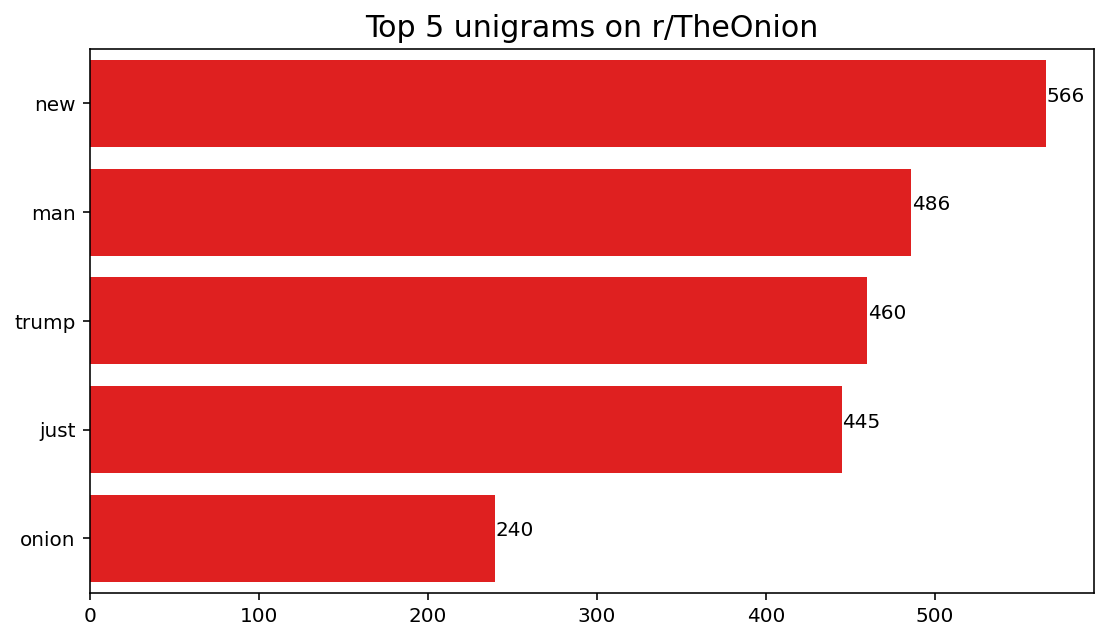

In [25]:
# Set up variables to contain top 5 most used words in Onion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 unigrams on r/TheOnion','r')

### r/nottheonion: Top 5 Unigrams

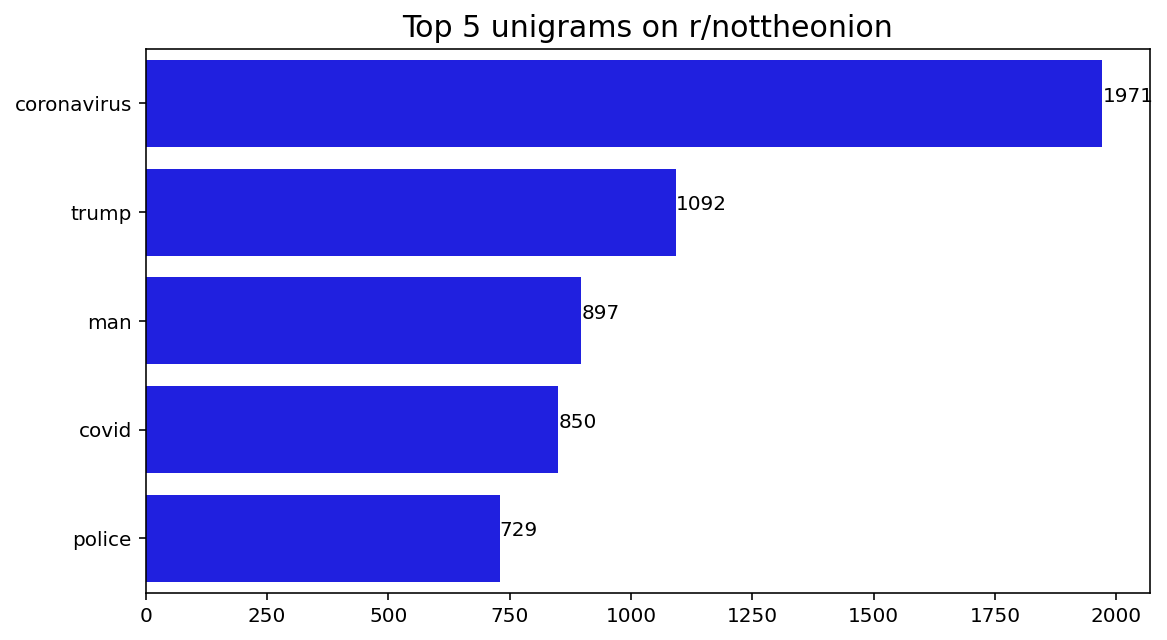

In [26]:
# Set up variables to contain top 5 most used words in Onion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 unigrams on r/nottheonion','b')



### Common Unigrams between Top 5 in r/TheOnion & r/nottheonion

In [27]:
# Create list of unique words in top five
not_onion_5_set = set(nonion_top_5.index)
onion_5_set = set(onion_top_5.index)

# Return common words
common_unigrams = onion_5_set.intersection(not_onion_5_set)
common_unigrams

{'man', 'trump'}

### Count Vectorize df where subreddit is 1

In [28]:
# Set variables to show TheOnion Titles
mask = df['subreddit'] == 1
df_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
onion_cvec = cv.fit_transform(df_onion_titles)

# Convert onion_cvec into a DataFrame
onion_cvec_df = pd.DataFrame(onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Onion Titles cvec
print(onion_cvec_df.shape)

(14013, 53286)


### Count Vectorize df where subreddit is 0

In [29]:
# Set variables to show NotTheOnion Titles
mask = df['subreddit'] == 0
df_not_onion_titles = df[mask]['title']

# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
not_onion_cvec = cv.fit_transform(df_not_onion_titles)

# Convert onion_cvec into a DataFrame
not_onion_cvec_df = pd.DataFrame(not_onion_cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(not_onion_cvec_df.shape)

(11802, 59415)


### r/TheOnion: Top 5 Bigrams

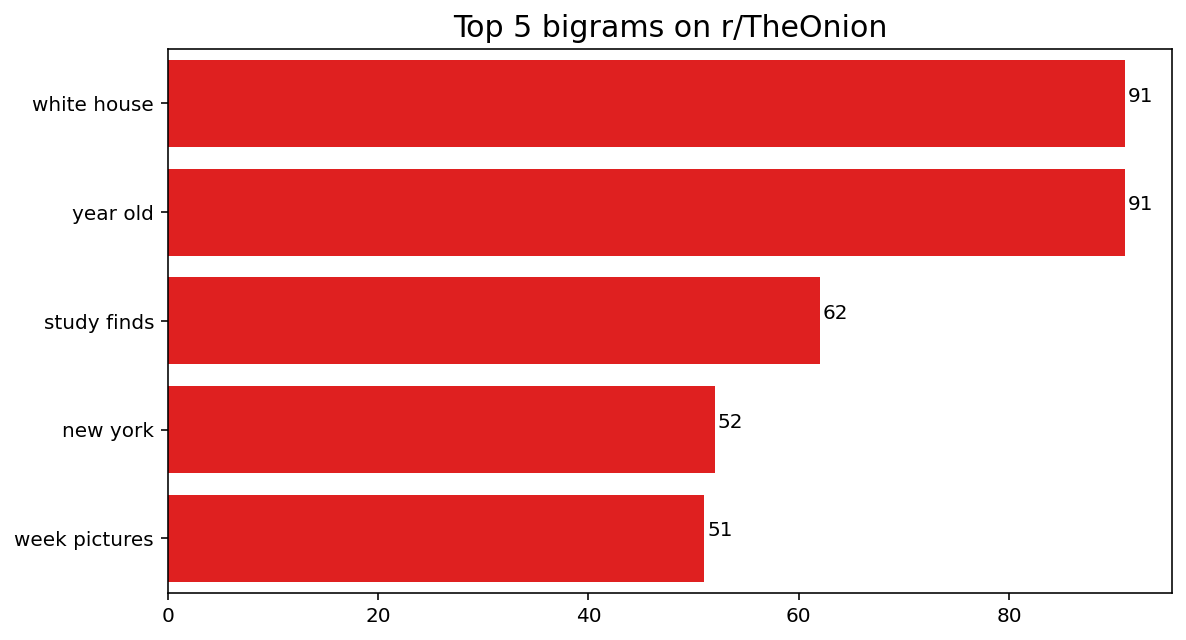

In [30]:
# Set up variables to contain top 5 most used bigrams in r/TheOnion
onion_wc = onion_cvec_df.sum(axis = 0)
onion_top_5 = onion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(onion_top_5.values, onion_top_5.index, 'Top 5 bigrams on r/TheOnion','r')

### r/nottheonion: Top 5 Bigrams

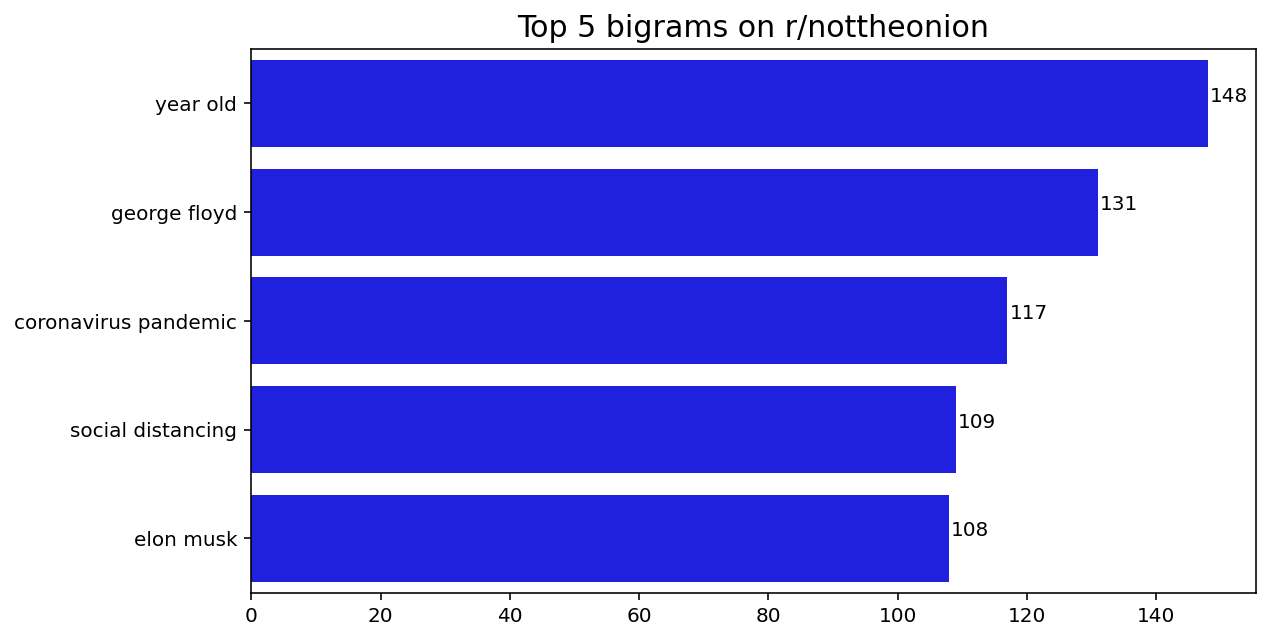

In [31]:
# Set up variables to contain top 5 most used bigrams in r/nottheonion
nonion_wc = not_onion_cvec_df.sum(axis = 0)
nonion_top_5 = nonion_wc.sort_values(ascending=False).head(5)

# Call function
bar_plot(nonion_top_5.values, nonion_top_5.index, 'Top 5 bigrams on r/nottheonion','b')


### Common Bigrams between Top 5 in r/TheOnion & r/nottheonion

In [32]:
not_onion_5_list = set(nonion_top_5.index)
onion_5_list = set(onion_top_5.index)

# Return common words
common_bigrams = onion_5_list.intersection(not_onion_5_list)
common_bigrams

{'year old'}

### Create custom stop_words to include common frequent words

In [33]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

## Modeling

### Baseline Score

In [34]:
# Baseline score
df['subreddit'].value_counts(normalize=True)

1    0.542824
0    0.457176
Name: subreddit, dtype: float64

### Set X (predictor) and y (target) variables

In [35]:
X = df['title']
y = df['subreddit']


### Train/Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

### Model 1: CountVectorizer & Logistic Regression (Best Coefficient Interpretability)

In [37]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8525387571576046
Train score 0.9605392283456433
Test score 0.8611713665943601


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

### Model 2: TfidfVectorize & Logistic Regression

In [38]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8494397756749626
Train score 0.9176695418625072
Test score 0.858072513170127


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 3,
 'tvect__ngram_range': (1, 3)}


### Model 3: CountVectorizer & MultinomialNB (Best Accuracy Score)

In [39]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8782087055290964
Train score 0.9948349775321522
Test score 0.8875116207003408


{'cvec__ngram_range': (1, 3), 'nb__alpha': 0.6}


### Model 4: TfidfVectorizer & MultinomialNB

In [40]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Best score: 0.8616808888831985
Train score 0.919064097928826
Test score 0.8605515959095135


{'nb__alpha': 0.1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 4,
 'tvect__ngram_range': (1, 2)}

## Best Models

### CountVectorizer & MultinomialNB: Best Score

In [41]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train)

Xcvec_train = cvec.transform(X_train)
Xcvec_test = cvec.transform(X_test)

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.8873566780291292


### Confusion Matrix

In [42]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2580,  371],
       [ 356, 3147]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

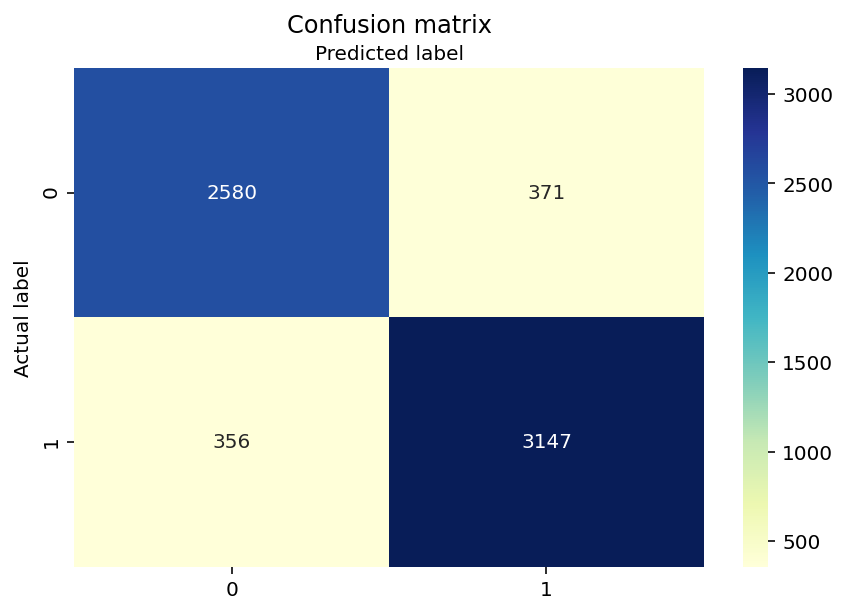

In [43]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [44]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [45]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 88.74 %
Precision: 89.45 %
Recall: 89.84 %
Specificity: 87.43 %
Misclassification Rate: 12.35 %


### CountVectorizer & Logistic Regression: Best Coefficient Interpretability

In [46]:
# Customize stop_words to include `onion` so that it doesn't appear
# in coefficients 

stop_words_onion = stop_words.ENGLISH_STOP_WORDS
stop_words_onion = list(stop_words_onion)
stop_words_onion.append('onion')

In [47]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = stop_words_onion)

# Fit and transform the vectorizor
cvec2.fit(X_train)

Xcvec2_train = cvec2.transform(X_train)
Xcvec2_test = cvec2.transform(X_test)

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.8591571118686087


### Coefficient Analysis

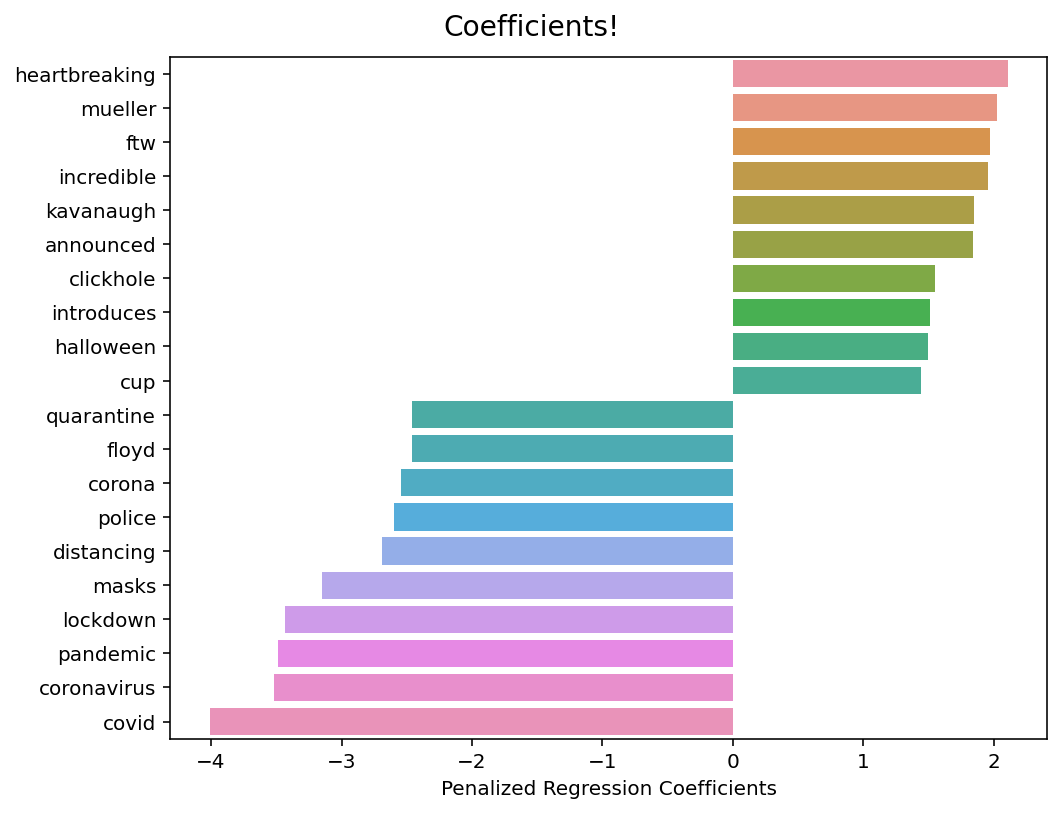

In [48]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [49]:
print("The word that contributes the most positively to being from r/TheOnion is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

The word that contributes the most positively to being from r/TheOnion is heartbreaking followed by mueller and ftw .
-----------------------------------
The word that contributes the most positively to being from r/nottheonion is covid followed by coronavirus and pandemic .


In [50]:
# Show coefficients that affect r/TheOnion
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
heartbreaking,2.106,8.215314
mueller,2.027,7.591278
ftw,1.968,7.156349
incredible,1.956,7.070986
kavanaugh,1.852,6.372552
announced,1.838,6.283958
clickhole,1.552,4.720903
introduces,1.512,4.535793
halloween,1.497,4.468264
cup,1.440,4.220696


In [51]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion.")

As occurences of heartbreaking increase by 1 in a title, that title is 8.22 times as likely to be classified as r/TheOnion.


In [52]:
# Show coefficients that affect r/nottheonion
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
covid,-4.008,55.036687
coronavirus,-3.520,33.784428
pandemic,-3.487,32.687737
lockdown,-3.433,30.969412
masks,-3.151,23.359412
distancing,-2.691,14.746415
police,-2.600,13.463738
corona,-2.544,12.730491
floyd,-2.462,11.728245
quarantine,-2.458,11.681425


In [53]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")

As occurences of covid increase by 1 in a title, that title is 55.04 times as likely to be classified as r/nottheonion.
